In [1]:
#%pip install selenium
%pip install tqdm
from html.parser import HTMLParser
import re
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import os
from tqdm import tqdm
import pickle
import getpass

Note: you may need to restart the kernel to use updated packages.


### Helper Functions

In [31]:
# function will determine the height of the body to calculate the scrolling distance, scroll down to the bottom, wait for a while for the AJAX to load new content, calculate new scrolling distance and scroll down again. It will stop when no new content can be loaded.

def get_fb_page(url, driver):
    time.sleep(10)
    driver.get(url)

    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        print("Getting friends...")
        # Wait to load page
        
        time.sleep(30) # adjust this if it breaks before!

        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
    html_source = driver.page_source
    return html_source

In [32]:
# MyHTMLParser is a class which helps us to find the URLs to friends’ home page. 
# find_friend_from_url function simply directs us to a friend’s home page by a given URL

def find_friend_from_url(url):
    if re.search('com\/profile.php\?id=\d+\&', url) is not None:
        m = re.search('com\/profile.php\?id=(\d+)\&', url)
        friend = m.group(1)
    else:
        m = re.search('com\/(.*)', url)
        friend = m.group(1)
    return friend

class MyHTMLParser(HTMLParser):
    urls = []

    def error(self, message):
        pass

    def handle_starttag(self, tag, attrs):
        # Only parse the 'anchor' tag.
        if tag == "a":
            # Check the list of defined attributes.
            condition_url_fine = False # all must be true in order to add the url
            condition_role_fine = False # all must be true in order to add the url
            condition_tabindex_fine = False # all must be true in order to add the url
            current_url = ""
            for name, value in attrs:
                # If href is defined, print it.
                if name == "href":
                    if re.search('www.facebook.com\/(?!.*photo|laurenz|video|stories|events|groups|profile|notifications|pages|marketplace).*(?<!friends_mutual)$', value) is not None: # specific regex that excludes facebook.com/ links that have photo or laurenz afterwards and should end with friends_mutual
                        # When the name is followed by / then go next, because it will not be a real name
                        if re.search('www.facebook.com\/(?!photo|laurenz|video|stories|events|groups|profile|notifications|pages|marketplace).+\/.*$', value) is not None:
                            continue
                        condition_url_fine = True
                        current_url = value
                if name == "role":
                    if value == "link":
                        condition_role_fine = True
                if name == "tabindex":
                    if value == "0":
                        condition_tabindex_fine = True
            if condition_url_fine and condition_role_fine and condition_tabindex_fine:
                self.urls.append(current_url)

### Fetch homepage URL's of my friends

In [ ]:
# Make sure wbdriver is installed
%pip install webdriver-manager
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
# Login
username = input("Facebook username:")
password = getpass.getpass('Password:')

chrome_options = webdriver.ChromeOptions()
prefs = {"profile.default_content_setting_values.notifications": 2}
chrome_options.add_experimental_option("prefs", prefs)
driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)

# Go to facebook.com and login
driver.get('http://www.facebook.com/')

# authenticate to facebook account
elem = driver.find_element_by_id("email")
elem.send_keys(username)
elem = driver.find_element_by_id("pass")
elem.send_keys(password)
elem.send_keys(Keys.RETURN)
print("Wait for 2FA...")
time.sleep(60)
print("Successfully logged in Facebook!")

print("Now logged in and go to look at friends")

my_url = 'http://www.facebook.com/' + username + '/friends'

UNIQ_FILENAME = 'uniq_urls.pickle'
if os.path.isfile(UNIQ_FILENAME):
    with open(UNIQ_FILENAME, 'rb') as f:
        uniq_urls = pickle.load(f)
    print('We loaded {} unique friends'.format(len(uniq_urls)))
else:
    print("Get friends page")
    friends_page = get_fb_page(my_url, driver)
    parser = MyHTMLParser()
    parser.feed(friends_page)
    uniq_urls = set(parser.urls)

    print('We found {} friends, saving it'.format(len(uniq_urls)))

    with open(UNIQ_FILENAME, 'wb') as f:
        pickle.dump(uniq_urls, f)

Next, we will use the URLs collected above to access the mutual friend page of each friend and retrieve the list of mutual friends. This is a slightly tricky part as Facebook are not happy with repetitive activities even you check your own friend list. It could temporarily ban you from accessing friend pages if you request more than 100 pages in one go. As such, the script is set to pause for half an hour at every 100 pages. If you are still uncomfortable with this rate, I would suggest further reduce the rate and leave the script running overnight. It will get the job done eventually.

In [33]:
# Make sure wbdriver is installed
#%pip install webdriver-manager
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
# Login
username = input("Facebook username:")
password = getpass.getpass('Password:')

chrome_options = webdriver.ChromeOptions()
prefs = {"profile.default_content_setting_values.notifications": 2}
chrome_options.add_experimental_option("prefs", prefs)
driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)

# Go to facebook.com and login
driver.get('http://www.facebook.com/')

# authenticate to facebook account
elem = driver.find_element_by_id("email")
elem.send_keys(username)
elem = driver.find_element_by_id("pass")
elem.send_keys(password)
elem.send_keys(Keys.RETURN)
print("Wait for 2FA...")
time.sleep(60)
print("Successfully logged in Facebook!")

print("Now logged in and go to look at friends")


#################################################################

# for user
username = "laurenz.a250994"
# need to pause every 100 friends
friend_graph = {}
GRAPH_FILENAME = 'friend_graph.pickle'

if os.path.isfile(GRAPH_FILENAME):
    with open(GRAPH_FILENAME, 'rb') as f:
        friend_graph = pickle.load(f)
    print('Loaded existing graph, found {} keys'.format(len(friend_graph.keys())))

count = 0

# Load unique URLS
UNIQ_FILENAME = 'uniq_urls.pickle'
with open(UNIQ_FILENAME, 'rb') as f:
        uniq_urls = pickle.load(f)
print('We loaded {} uniq friends'.format(len(uniq_urls)))

for url in tqdm(uniq_urls):

    count += 1
    #if count % 40 == 0:
        #print ("Too many queries, pause for a while...")
        #time.sleep(300)

    friend_username = find_friend_from_url(url)
    # if it already exists, skip
    if (friend_username in friend_graph.keys()) and (len(friend_graph[friend_username]) > 1):
        continue

    print("Get friend page for: {}".format(friend_username))

    # get friend page
    friend_graph[friend_username] = [username]
    mutual_url = 'https://www.facebook.com/{}/friends_mutual'.format(friend_username)
    mutual_page = get_fb_page(mutual_url, driver)

    parser = MyHTMLParser()
    parser.urls = []
    parser.feed(mutual_page)
    mutual_friends_urls = set(parser.urls)
    print('Found {} urls'.format(len(mutual_friends_urls)))
    
    # append mutual friends in list
    for mutual_url in mutual_friends_urls:
        mutual_friend = find_friend_from_url(mutual_url)
        friend_graph[friend_username].append(mutual_friend)

    with open(GRAPH_FILENAME, 'wb') as f:
        pickle.dump(friend_graph, f)

    time.sleep(5)




====== WebDriver manager ======
Current google-chrome version is 100.0.4896
Get LATEST chromedriver version for 100.0.4896 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/100.0.4896.60/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\laise\.wdm\drivers\chromedriver\win32\100.0.4896.60]
C:\Users\laise\AppData\Local\Temp\ipykernel_5820\652507189.py:12: DeprecationWarning:

executable_path has been deprecated, please pass in a Service object

C:\Users\laise\AppData\Local\Temp\ipykernel_5820\652507189.py:18: DeprecationWarning:

find_element_by_* commands are deprecated. Please use find_element() instead

C:\Users\laise\AppData\Local\Temp\ipykernel_5820\652507189.py:20: DeprecationWarning:

find_element_by_* commands are deprecated. Please use find_element() instead



Wait for 2FA...
Successfully logged in Facebook!
Now logged in and go to look at friends
Loaded existing graph, found 764 keys
We loaded 764 uniq friends


  0%|          | 0/764 [00:00<?, ?it/s]

Get friend page for: notifications/
Getting friends...
Getting friends...
Getting friends...


## Plotting

https://gist.github.com/EliotAndres/efbd6f2b5ee4375870ed8e55a933871d

In [1]:
'''
Remove "notifications" from the graph
'''

'\nRemove "notifications" from the graph\n'

In [2]:
import pickle 

friend_graph = {}
GRAPH_FILENAME = 'friend_graph.pickle'

if os.path.isfile(GRAPH_FILENAME):
    with open(GRAPH_FILENAME, 'rb') as f:
        friend_graph = pickle.load(f)
    print('Loaded existing graph, found {} keys'.format(len(friend_graph.keys())))

Loaded existing graph, found 764 keys


In [3]:
friend_graph

{'sophie.lutterbach': ['laurenz.a250994',
  'sarah.burkert',
  'joshua.grittmann',
  'sophie.lutterbach',
  'sandra.burgert.7',
  'anna.haag.33',
  'fabian.grimm.566',
  'niko.genz',
  'kerem.dbk',
  'marie.csu',
  'maike.blessing',
  'mirko.capelle',
  'corinna.haas.3',
  'moritz.kleinholz',
  'melanie.burp',
  'dean.exner.7',
  'elsa.win.5',
  'anika.geiger',
  'pusadel',
  'awd94',
  'carolina.fuenfgeld',
  'mirco.philipp',
  'unddasistmeinnutzername',
  'jonathan.bernecker',
  'lasse.greulich',
  'oliver.zimmermann.733',
  'sebastian.geiler',
  'LucasJOG',
  'dorian.marckmann',
  'jonas.gassenschmidt',
  'laura.lang.144',
  'alina.maria.1460',
  'livia.helena.100',
  'nana.hassler',
  'lara.ahlgrimm.9',
  'moritz.fuenfgeld',
  'christoph.muller.756859',
  'cara.bien',
  'annika.schelb',
  'niklas.sell',
  'julia.fricker.1',
  'david.pflug.18',
  'katja.vonrauchhaupt',
  'sandro.scherrers',
  'dominik.nies.75',
  'alexandra.oe.7',
  'alina.petrovic.5',
  'philipp.haberle.1',
  'jani

In [3]:
GRAPH_FILENAME = 'uniq_urls.pickle'

if os.path.isfile(GRAPH_FILENAME):
    with open(GRAPH_FILENAME, 'rb') as f:
        friend_graph = pickle.load(f)
    print('Loaded existing graph, found {} urls'.format(len(friend_graph)))

NameError: name 'pickle' is not defined

In [1]:
# Setting for plotting graph in the Jupyter Notebook
%matplotlib inline
import matplotlib.pyplot as plt
# Set the size of the graph
plt.rcParams['figure.figsize'] = [10, 10]

import community
import networkx as nx
import colorlover as cl
import numpy as np
import pickle

#py.init_notebook_mode(connected=True)

# This is your Facebook id. It can also be a number
CENTRAL_ID = 'laurenz.a250994'

# This is the pickle file containing the raw graph data
GRAPH_FILENAME = 'friend_graph.pickle'

# Load the friend_graph picklefile
with open(GRAPH_FILENAME, 'rb') as f:
    friend_graph = pickle.load(f)

In [2]:
# Only keep friends with at least 2 common friends
central_friends = {}

for k, v in friend_graph.items():
    # This contains the list number of mutual friends.
    # Doing len(v) does not work because instead of returning mutual
    # friends, Facebook returns all the person's friends
    intersection_size = len(np.intersect1d(list(friend_graph.keys()), v))
    if intersection_size > 2:
        central_friends[k] = v
    else:
        print("Removed: {0} ".format(k))

print('Filtered out {} items'.format(len(friend_graph.keys()) - len(central_friends.keys())))

Removed: nasya.rasmussen 
Removed: esra.arslan.73 
Removed: alessiosilvano.dilauro 
Removed: kristoffer.bregengaard 
Removed: pages/NBA-Game-Toronto-Raptors-Air-Canada-Centre/221622977946700 
Removed: philipp.haha.9 
Removed: esther.euteneuer 
Removed: caroline.devesen 
Removed: moritz.wurzelemquadrat 
Removed: MarcoBombastic 
Removed: nikola.zemite 
Removed: notifications/ 
Removed: ida.snak 
Removed: lucie.perez.528 
Removed: marta.musso.758 
Removed: staufenersc/ 
Removed: galo.vargas 
Removed: kapoorag 
Removed: tess.sanny 
Removed: henry.hildebrand.3 
Removed: chelsbenji 
Removed: katarina.paunovic.7 
Removed: whornung 
Removed: va.le.1293 
Removed: dori.fekete.39 
Removed: fourzero.ent 
Removed: autohaus.holz/ 
Removed: amelie.reinold 
Removed: lereig 
Removed: ryan.hutchinson23 
Removed: 7erClubMannheim/ 
Removed: ramona.schuler.5 
Removed: caro.madison 
Removed: johanne.liebmann/posts/10227680249140932?notif_id=1649230935426504&notif_t=nf_status_story&ref=notif 
Removed: hannah

In [3]:
# Extract edges from graph

edges = []
nodes = [CENTRAL_ID]

for k, v in central_friends.items():
    for item in v:
        if item in central_friends.keys() or item == CENTRAL_ID:
            if k == item: # if connected to itself
                continue
            edges.append((k, item))

In [4]:
G = nx.Graph()
G.add_nodes_from([CENTRAL_ID])
G.add_nodes_from(central_friends.keys())

G.add_edges_from(edges)
print('Added {} edges'.format(len(edges) ))

Added 23811 edges


In [8]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot, plot
#%pip install python-louvain
from community import community_louvain

nodeID = G.nodes().keys()
part = community_louvain.best_partition(G, resolution=0.87) # get communities with louvain method


class MyGraph(nx.Graph):

  def add_relation(self, node_from, node_to):
    self.add_node(node_from)
    self.add_node(node_to)
    self.add_edge(node_from, node_to)

  def plot(self):

    colors = cl.scales['12']['qual']['Paired']
    # nodeID = self.nodes().keys()
    marker_color = []
    for node in nodeID:
        color = colors[part[node] % len(colors)] #into colors using color lovers
        marker_color.append(color)


    # Nodes
    pos=nx.fruchterman_reingold_layout(self)  # calculates the positions of the nodes
    Xn=[pos[k][0] for k in pos.keys()]
    Yn=[pos[k][1] for k in pos.keys()]
    trace_nodes=dict(type='scatter',
                     x=Xn, 
                     y=Yn,
                     mode='markers',
                     marker=dict(size=16, color=marker_color), 
                     text=list(pos.keys()),
                     hoverinfo='text')
                     
    # Edges
    Xe=[]
    Ye=[]
    for e in G.edges():
        Xe.extend([pos[e[0]][0], pos[e[1]][0], None])
        Ye.extend([pos[e[0]][1], pos[e[1]][1], None])
    trace_edges=dict(type='scatter',
                     mode='lines',
                     x=Xe,
                     y=Ye,
                     line=dict(width=0.4, color='#e0e0e0'),
                     hoverinfo='none' 
                    )


    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
              zeroline=False,
              showgrid=False,
              showticklabels=False,
              title='' 
              )

    layout=dict(title= '<b>Facebook Friends Graph</b>',  
                font= dict(family='Courier New', size=20),
                width=1100,
                height=1100,
                autosize=False,
                showlegend=False,
                xaxis=axis,
                yaxis=axis,
                margin=dict(
                l=40,
                r=40,
                b=85,
                t=100,
                pad=0,

        ),
        hovermode='closest',
        plot_bgcolor='#36454F', #set background color            
        )


    fig = dict(data=[trace_edges, trace_nodes], layout=layout)
    iplot(fig)
    

In [9]:
my_plot = MyGraph(G)

fig = my_plot.plot()

### Alternative Graph

You should consider upgrading via the 'c:\Users\laise\Desktop\Coding_Projects\FriendsGraph_Venv\env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


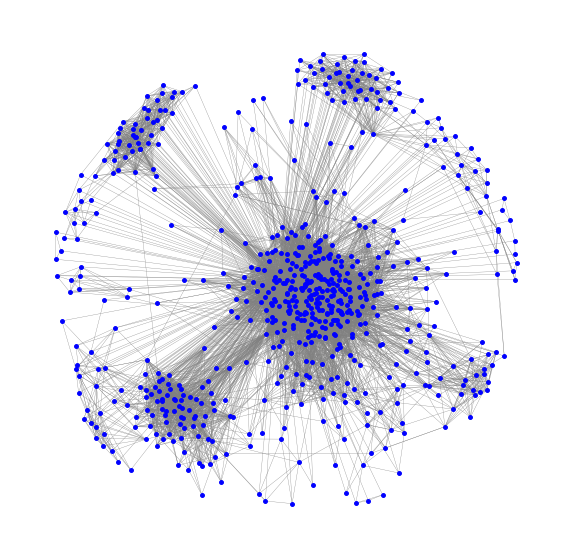

: 

In [10]:
%pip install scipy
pos = nx.spring_layout(G) # get the position using the spring layout algorithm

plt.rcParams['figure.figsize'] = [10, 10]
nx.draw_networkx(G, pos = pos, with_labels=False, 
                 node_size=15, width=0.3, node_color='blue', edge_color='grey')
limits=plt.axis('off') # turn of axis